In [1]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [2]:
ls

3DUnetCNN/                                   resize.ipynb
3D_Unet_ipynb.ipynb                          resize_patch.ipynb
3D_Unet_ipynb.ipynb:Zone.Identifier          result/
3D_Unet_nulti.ipynb                          result_image/
Liver-Segmentation-Using-Monai-and-PyTorch/  sandstone_data_for_ML/
dataset/                                     sandstone_data_for_ML.zip
mri_segment/                                 tutorial122_3D_Unet.ipynb


In [3]:
# Latest Tensorflow (2.4) is giving error for some of the libraries we will be using,
# especially segmentation models 3D.
# Therefore, I am defining TF version 1.x.
# If you have your own 3D unet model, you can try the latest TF version.
!pip install tensorflow==2.8.4
#%tensorflow_version 2.x
!pip install tensorflow==2.13.0


In [4]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
#!pip install classification-models-3D
#!pip install efficientnet-3D
#!pip install segmentation-models-3D

In [5]:
#Use patchify to break large volumes into smaller for training
#and also to put patches back together after prediction.
#!pip install patchify

In [6]:
import tensorflow as tf
#import tensorflow.python.keras as keras
import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [7]:
#Make sure the GPU is available.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
import segmentation_models_3D as sm


Segmentation Models: using `tf.keras` framework.


In [9]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [10]:
#!mv /content/sandstone_data_for_ML /content/drive/MyDrive/


In [11]:
import nibabel as nib
#Load input images and masks.
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training.
patch_size = 64
stepsize=64
image_path = '/home/chae/segmentation/dataset/mr_train/mr_train_1001_image.nii.gz'
image_obj = nib.load(image_path)
image_data = image_obj.get_fdata()
print("imageshpae: ",image_data.shape)
img_patches = patchify(image_data, (patch_size,patch_size,patch_size), step=stepsize)  #Step=64 for 64 patches means no overlap
mask_path = '/home/chae/segmentation/dataset/mr_train/mr_train_1001_label.nii.gz'
mask_obj = nib.load(mask_path)
mask_data = mask_obj.get_fdata()
print("masksize: ",mask_data.shape)

mask_patches = patchify(mask_data, (patch_size,patch_size,patch_size), step=stepsize)
print("Number of patches:", img_patches.shape)


imageshpae:  (512, 512, 160)
masksize:  (512, 512, 160)
Number of patches: (8, 8, 2, 64, 64, 64)


In [12]:
# from scipy.ndimage import zoom

# # 원본 이미지 데이터: image_data
# # 다운사이징 비율
# scale = 0.5  # 예시로 50% 축소

# # 이미지 다운사이징
# downsized_image_data = zoom(image_data, (scale, scale, scale))
# downsized_mask_data = zoom(mask_data, (scale, scale, scale), order=0)

# # 결과 확인
# print("Original shape:", image_data.shape)
# print("Downsized shape:", downsized_image_data.shape)


In [13]:
# image_data = downsized_image_data
# mask_data = downsized_mask_data 

In [14]:
#plt.imshow(img_patches[1,2,3,:,:,32])
# 예를 들어 4개의 패치를 표시하고자 할 때
#fig, axs = plt.subplots(2, 2) # 2x2 그리드로 서브플롯 생성

# 첫 번째 서브플롯
# axs[0, 0].imshow(mask_patches[13,15,5,:,:,32])
# axs[0, 0].set_title('Patch 0,0,0')

# # 두 번째 서브플롯
# axs[0, 1].imshow(mask_patches[3,10,0,:,:,32])
# axs[0, 1].set_title('Patch 0,1,0')

# # 세 번째 서브플롯
# axs[1, 0].imshow(mask_patches[4,0,0,:,:,32])
# axs[1, 0].set_title('Patch 1,0,0')

# # 네 번째 서브플롯
# axs[1, 1].imshow(mask_patches[5,1,0,:,:,32])
# axs[1, 1].set_title('Patch 1,1,0')

# # 전체 레이아웃 조정
# plt.tight_layout()
# plt.show()


In [15]:

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z



(128, 64, 64, 64)


In [16]:
print(img_patches.shape)

(8, 8, 2, 64, 64, 64)


In [17]:
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)
unique_values = np.unique(train_mask)
print(unique_values)


[  0. 205. 420. 500. 550. 600. 820. 850.]


In [18]:
def remap_label(label):
    # 0 레이블을 제외한 나머지 레이블 매핑
    label_mapping = {0:0 , 205: 1, 420: 2, 500: 3, 550: 4, 600: 5, 820: 6, 850: 7}
    return label_mapping.get(label, -1)  # 존재하지 않는 레이블은 -1로 처리

# train_mask의 모든 요소에 대해 remap_label 함수 적용
train_mask_remap = np.vectorize(remap_label)(train_mask)

# 새로운 레이블 값 확인
# -1 값을 제외하고 unique 값을 찾기
unique_values_remap = np.unique(train_mask_remap[train_mask_remap != -1])
print(unique_values_remap)



[0 1 2 3 4 5 6 7]


In [19]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input.

# train_img = np.stack((input_img,)*3, axis=-1)
# train_mask = np.expand_dims(input_mask, axis=4)
# unique_values = np.unique(train_mask)
# print(unique_values)
n_classes = 8

train_mask_cat = to_categorical(train_mask_remap, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.20, random_state = 0)



In [20]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [21]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
#patch_size = 64
channels=3
import tensorflow as tf

LR = 0.000001
optim = tf.keras.optimizers.Adam(LR)


# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25, 0.25, 0.25,0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [22]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
#Preprocess input data - otherwise you end up with garbage resutls
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [24]:
print(f"X_train shape: {np.array(X_train).shape}")
print(f"y_train shape: {np.array(y_train).shape}")
print(f"X_test shape: {np.array(X_test).shape}")
print(f"y_test shape: {np.array(y_test).shape}")

X_train shape: (102, 64, 64, 64, 3)
y_train shape: (102, 64, 64, 64, 8)
X_test shape: (26, 64, 64, 64, 3)
y_test shape: (26, 64, 64, 64, 8)


In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [26]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1717280420935201521
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7745830912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10707049948591449567
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:2b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [27]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                                64)                                                           

In [28]:
print (X_train_prep.shape)
print (y_train.shape)

(102, 64, 64, 64, 3)
(102, 64, 64, 64, 8)


In [30]:
#Fit the model
history=model.fit(X_train_prep,
          y_train,
          batch_size=1,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Epoch 1/100
102/102 [==============================] - 12s 120ms/step - loss: 1.0727 - iou_score: 0.0810 - f1-score: 0.0811 - val_loss: 1.0752 - val_iou_score: 0.3129 - val_f1-score: 0.3133
Epoch 2/100
102/102 [==============================] - 12s 116ms/step - loss: 1.0705 - iou_score: 0.0896 - f1-score: 0.0897 - val_loss: 1.0746 - val_iou_score: 0.3177 - val_f1-score: 0.3181
Epoch 3/100
102/102 [==============================] - 11s 113ms/step - loss: 1.0683 - iou_score: 0.1043 - f1-score: 0.1044 - val_loss: 1.0716 - val_iou_score: 0.3273 - val_f1-score: 0.3276
Epoch 4/100
102/102 [==============================] - 11s 112ms/step - loss: 1.0663 - iou_score: 0.1067 - f1-score: 0.1068 - val_loss: 1.0697 - val_iou_score: 0.3224 - val_f1-score: 0.3228
Epoch 5/100
102/102 [==============================] - 11s 112ms/step - loss: 1.0644 - iou_score: 0.1141 - f1-score: 0.1141 - val_loss: 1.0665 - val_iou_score: 0.3272 - val_f1-score: 0.3275
Epoch 6/100
102/102 [=============================

In [31]:
#Save model for future use
model.save('/home/chae/segmentation/result/3D_mrmodel_vgg16_100epochs_2.h5')

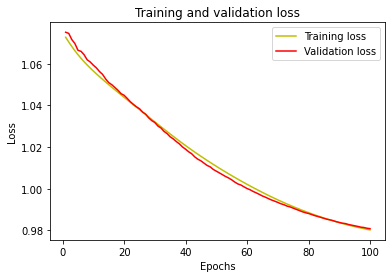

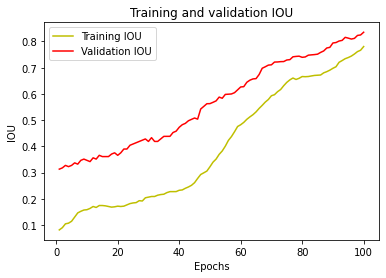

In [32]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # import numpy as np
# # import nibabel as nib
# # import tensorflow as tf
# # import segmentation_models as sm

# # 여기에 dice_coefficient 및 dice_coefficient_loss 함수 정의

# # 모델을 불러올 때 사용할 custom_objects
# custom_objects = {
#     'dice_loss_plus_1focal_loss': lambda y_true, y_pred: sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(),
#     'dice_coefficient': dice_coefficient,
#     'dice_coefficient_loss': dice_coefficient_loss,
#     'DiceLoss': sm.losses.DiceLoss,
#     'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss,
#     'iou_score': sm.metrics.IOUScore,
#     'f1-score': sm.metrics.FScore
# }

# # 모델 불러오기
# model = tf.keras.models.load_model('/home/chae/segmentation/result/3D_model_vgg16_100epochs.h5', custom_objects=custom_objects)

# resized_image_data = zoom(downsized_image_data, (64 / downsized_image_data.shape[0], 64 / downsized_image_data.shape[1], 64 / downsized_image_data.shape[2]))

# # 채널 차원 추가 (회색조 이미지를 3채널로 변환)
# resized_image_data = np.stack((resized_image_data,)*3, axis=-1)

# # 배치 차원 추가
# resized_image_data = np.expand_dims(resized_image_data, axis=0)

# # 모델 적용
# segmented = model.predict(resized_image_data)
# # 모델 적용

# # 결과 처리
# segmented_result = np.argmax(segmented, axis=-1)
# segmented_result = np.squeeze(segmented_result)

# # 데이터 타입을 float32 또는 int16으로 변환
# segmented_result = segmented_result.astype(np.float32)  # 또는 np.int16

# # NIfTI 파일로 저장
# new_nii = nib.Nifti1Image(segmented_result, affine=np.eye(4), dtype=np.float32)  # affine 매트릭스는 예시입니다
# nib.save(new_nii, 'segmented_output.nii')

In [ ]:
# import itk
# import h5py
# import numpy as np

# # H5 파일 읽기
# with h5py.File('/home/chae/segmentation/result/3D_model_vgg16_100epochs.h5', 'r') as file:
#     dataset = file['/home/chae/segmentation/dataset/ct_test/ct_test_2001_image.nii.gz']
#     image_data = np.array(dataset)

# # ITK 이미지로 변환
# image_itk = itk.image_from_array(image_data)

# # ITK 이미지 처리 예시 (예: 스무딩)
# smoothed_image = itk.smoothing_recursive_gaussian_image_filter(image_itk, sigma=2.0)

# # 결과 저장 또는 추가 처리


In [33]:
#Predict on the test data
from keras.models import load_model
my_model = load_model('/home/chae/segmentation/result/3D_mrmodel_vgg16_100epochs_2.h5', compile=False)
print(f'Type of my_model: {X_test_prep.shape}')
y_pred=my_model.predict(X_test_prep)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


Type of my_model: (26, 64, 64, 64, 3)


In [34]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(26, 64, 64, 64)
(26, 64, 64, 64)
[0 1 2 3 4 5 6 7]


In [35]:
# Using built in keras function for IoU
# Only works on TF > 2.0
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.122231014


In [36]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)




(64, 64, 64)


In [37]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

(64, 64, 64, 3)


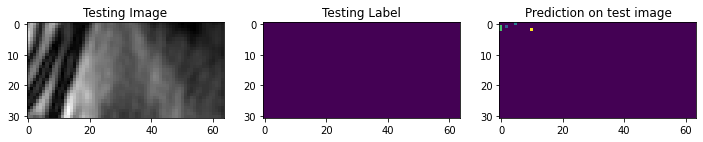

In [38]:
#Plot individual slices from test predictions for verification
slice = 31
slice1 = 31
slice2 = 31
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice1,:slice2,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:slice2,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:slice2,:])
plt.show()

Now segment the full volume using the trained model.

In [40]:
large_image_path = '/home/chae/segmentation/result_image/resized_mri_image.nii.gz'
large_image_obj = nib.load(large_image_path)
large_image_data = large_image_obj.get_fdata()
print("imageshpae: ",large_image_data.shape)
img_patches = patchify(large_image_data, (patch_size,patch_size,patch_size), step=stepsize)  #Step=64 for 64 patches means no overlap
print(large_image_data.shape)
print(img_patches.shape)

imageshpae:  (512, 512, 192)
(512, 512, 192)
(8, 8, 3, 64, 64, 64)


In [ ]:
# import numpy as np
# import nibabel as nib
# from patchify import patchify, unpatchify

# # 원본 이미지 데이터 로드
# image_path = '/home/chae/segmentation/dataset/ct_train/ct_train_1001_image.nii.gz'
# image_obj = nib.load(image_path)
# image_data = image_obj.get_fdata()

# # 원본 이미지 크기
# original_shape = image_data.shape

# # 패치 크기
# patch_size = 64

# # 필요한 패딩 계산
# padding = [(0, PS - (dim % PS)) for dim, PS in zip(original_shape, (patch_size, patch_size, patch_size))]
# padding = [(pad[0], max(pad[1], 0)) for pad in padding]  # 음수 패딩 방지

# # 이미지에 패딩 추가
# padded_image = np.pad(image_data, padding, mode='constant', constant_values=0)

# # 패딩된 이미지로 패치 생성
# img_patches = patchify(padded_image, (patch_size, patch_size, patch_size), step=patch_size)

# # 여기서 모델을 사용하여 예측을 수행하고, 예측된 패치를 얻습니다.
# # 예측된 패치를 재구성
# reconstructed_image = unpatchify(img_patches, padded_image.shape)

# # 원본 이미지 크기로 잘라내기
# reconstructed_image = reconstructed_image[:original_shape[0], :original_shape[1], :original_shape[2]]

# # 결과 확인
# print("Reconstructed image shape:", reconstructed_image.shape)
# print("padded_image shape:", padded_image.shape)


In [41]:
# Predict each 3D patch
predicted_patches = []
for i in range(img_patches.shape[0]):
  for j in range(img_patches.shape[1]):
    for k in range(img_patches.shape[2]):
      #print(i,j,k)
      single_patch = img_patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)



In [42]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(192, 64, 64, 64)


In [43]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (img_patches.shape[0], img_patches.shape[1], img_patches.shape[2],
                                         img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(8, 8, 3, 64, 64, 64)


In [44]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image_data.shape)
print(reconstructed_image.shape)

(512, 512, 192)


In [ ]:
# #when size unfit
# import numpy as np
# from patchify import unpatchify

# # 예시: predicted_patches_reshaped의 형태가 (8, 8, 5, 64, 64, 64)
# # 세 번째 차원(5)에서 마지막 패치를 제외하고 나머지 패치를 사용합니다.
# desired_shape = (512, 512, 160)
# reconstructed_image_resized = np.zeros(desired_shape)
# reconstructed_image_resized[:,:,:] = large_image_data[:,:,:160]

# # 마지막 패치를 제외한 패치 배열을 선택
# selected_patches = predicted_patches_reshaped[:, :, :, :, :, :]

# # 재구성된 이미지 생성
# # large_image_data.shape는 원본 이미지의 크기를 나타냅니다.
# reconstructed_image = unpatchify(selected_patches, reconstructed_image_resized.shape)

# print("Reconstructed image shape:", reconstructed_image.shape)


In [45]:
print(reconstructed_image.dtype)

int64


In [46]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [47]:
import os
original_nii = nib.load('/home/chae/segmentation/dataset/mr_train/mr_train_1001_image.nii.gz')

# 재구성된 이미지를 NIfTI 형식으로 저장
new_nii = nib.Nifti1Image(reconstructed_image, original_nii.affine, original_nii.header)

# 저장할 경로 지정
save_path = '/home/chae/segmentation/result_image/'

# 해당 경로에 폴더가 없으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 파일 저장
nib.save(new_nii, os.path.join(save_path, 'mr_multi_segmented.nii'))

print("Segmented NIfTI file saved at:", os.path.join(save_path, 'mr_multi_segmented.nii'))

Segmented NIfTI file saved at: /home/chae/segmentation/result_image/mr_segmented.nii


In [ ]:
#If you would like to save the volume as multichannel dataset....

In [ ]:
print(np.unique(reconstructed_image))

[0]


In [ ]:
# #Seperate each channel/segment to be combined as multiple channels.
# num_segments=4
# segm0 = (reconstructed_image == 0)
# segm1 = (reconstructed_image == 1)
# segm2 = (reconstructed_image == 2)
# segm3 = (reconstructed_image == 3)

# final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
# final[:,:,:,0] = segm0
# final[:,:,:,1] = segm1
# final[:,:,:,2] = segm2
# final[:,:,:,3] = segm3

In [ ]:
# #Use APEER OMETIFF library to read and write multidimensional images
# !pip install imagecodecs==2020.5.30
# !pip install --upgrade setuptools wheel
# !pip install apeer-ometiff-library --no-deps


In [ ]:
# from apeer_ometiff_library import io

In [ ]:
# # Expand image array to 5D of order (T, Z, C, X, Y)
# # This is the convention for OMETIFF format as written by APEER library
# final = np.expand_dims(final, axis=0)
# final=np.swapaxes(final, 2, 4)

# final = final.astype(np.int8)



In [ ]:
# print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
# print(final.dtype)


In [ ]:
# # Write dataset as multi-dimensional OMETIFF *image*
# io.write_ometiff("/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)